# Decision Tree for Alignment Conformance Checking in Process Mining

A decision tree is a powerful tool used in process mining for alignment conformance checking. It helps in identifying deviations between the observed behavior (event logs) and the modeled behavior (process models). Here’s how it works:

1. **Data Preparation**: Collect event logs that record the sequence of activities in a process. Ensure the logs are preprocessed to remove noise and irrelevant data.

2. **Feature Extraction**: Extract relevant features from the event logs. These features could include activity names, timestamps, resources, and other attributes.

3. **Model Training**: Use the extracted features to train a decision tree model. The decision tree learns to classify sequences of activities as conforming or non-conforming based on the training data.

4. **Conformance Checking**:
    - **Alignment**: Align the event logs with the process model to identify deviations. The decision tree helps in predicting whether a given sequence of activities conforms to the model.
    - **Deviation Analysis**: Analyze the non-conforming sequences to understand the nature of deviations. This can help in identifying bottlenecks, inefficiencies, or compliance issues in the process.

5. **Interpretation**: The decision tree provides a visual representation of the decision-making process, making it easy to interpret the results. Each path from the root to a leaf node represents a rule for classifying sequences.

6. **Continuous Improvement**: Use the insights gained from the conformance checking to improve the process model and ensure better alignment with the actual process execution.

By using a decision tree for alignment conformance checking, organizations can ensure that their processes are executed as intended, identify areas for improvement, and enhance overall process efficiency.

In [24]:
import pandas as pd

# Load the data from the CSV file
df = pd.read_csv('/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/data/df_for_decision_tree.csv')

# Display the first few rows of the dataframe
df.head()

trace_number  start_log_moves  start_model_moves  \
0             0                0                  0   
1             1                0                  0   
2             2                0                  0   
3             3                0                  0   
4             4                0                  0   

   A-Create-Application_log_moves  A-Create-Application_model_moves  \
0                               0                                 0   
1                               0                                 0   
2                               0                                 0   
3                               0                                 0   
4                               0                                 0   

   A-Submitted_log_moves  A-Submitted_model_moves  \
0                    0.0                      0.0   
1                    0.0                      0.0   
2                    NaN                      NaN   
3                    NaN                      NaN   
4                    0.0                      0.0   

   W-Handle-leads-schedule_log_moves  W-Handle-leads-schedule_model_moves  \
0                                0.0                                  0.0   
1                                0.0                                  0.0   
2                                NaN                                  NaN   
3                                NaN                                  NaN   
4                                0.0                                  0.0   

   W-Handle-leads-withdraw_log_moves  ...  \
0                                0.0  ...   
1                                0.0  ...   
2                                NaN  ...   
3                                NaN  ...   
4                                0.0  ...   

   W-Handle-leads-ate-abort_model_moves  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   

   W-Shortened-completion-schedule_log_moves  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   

   W-Shortened-completion-schedule_model_moves  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

   W-Shortened-completion-start_log_moves  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   W-Shortened-completion-start_model_moves  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   W-Shortened-completion-suspend_log_moves  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   W-Shortened-completion-suspend_model_moves  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   

   W-Call-after-offers-withdraw_log_moves  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                              

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score 


df_filled = df.fillna(0)

# Separate features (X) and target (y)
X = df_filled.drop(columns=["trace_number", "case:throughput_time"])
y = df_filled["case:throughput_time"].apply(pd.to_timedelta)  # Ensure column is timedelta

# Convert target variable 'case:throughput_time' to numeric (days) for modeling
y_days = y.apply(lambda x: x.total_seconds() / 86400)  # Convert timedelta to days

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_days, test_size=0.2, random_state=42)

# Define the Decision Tree model with a grid of hyperparameters for optimization
tree_regressor = DecisionTreeRegressor(random_state=42)

# Define a grid of hyperparameters for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 9, 10],
    'min_samples_split': [10, 15, 20, 25, 30, 40, 50],	
    'min_samples_leaf': [10, 15, 20, 25, 30, 40, 50],	
    'max_features': ['sqrt', 'log2', 0.05]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Extract the best model from the grid search
best_tree_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_days = best_tree_model.predict(X_test)

# Convert predictions back to timedelta format for interpretation
y_pred_timedelta = pd.Series(y_pred_days).apply(lambda days: pd.to_timedelta(days, unit='D'))
y_test_timedelta = pd.Series(y_test).apply(lambda days: pd.to_timedelta(days, unit='D'))

# Calculate evaluation metrics
precision = precision_score(y_test, y_pred_days, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred_days, average='weighted')
f1 = f1_score(y_test, y_pred_days, average='weighted')

print("Model Performance:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1: {f1}")


# Display first few results for interpretation
results_df = pd.DataFrame({
    'Actual Throughput Time': y_test_timedelta.reset_index(drop=True),
    'Predicted Throughput Time': y_pred_timedelta
})
print(results_df.head())


Fitting 5 folds for each of 735 candidates, totalling 3675 fits


/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


ValueError: continuous is not supported

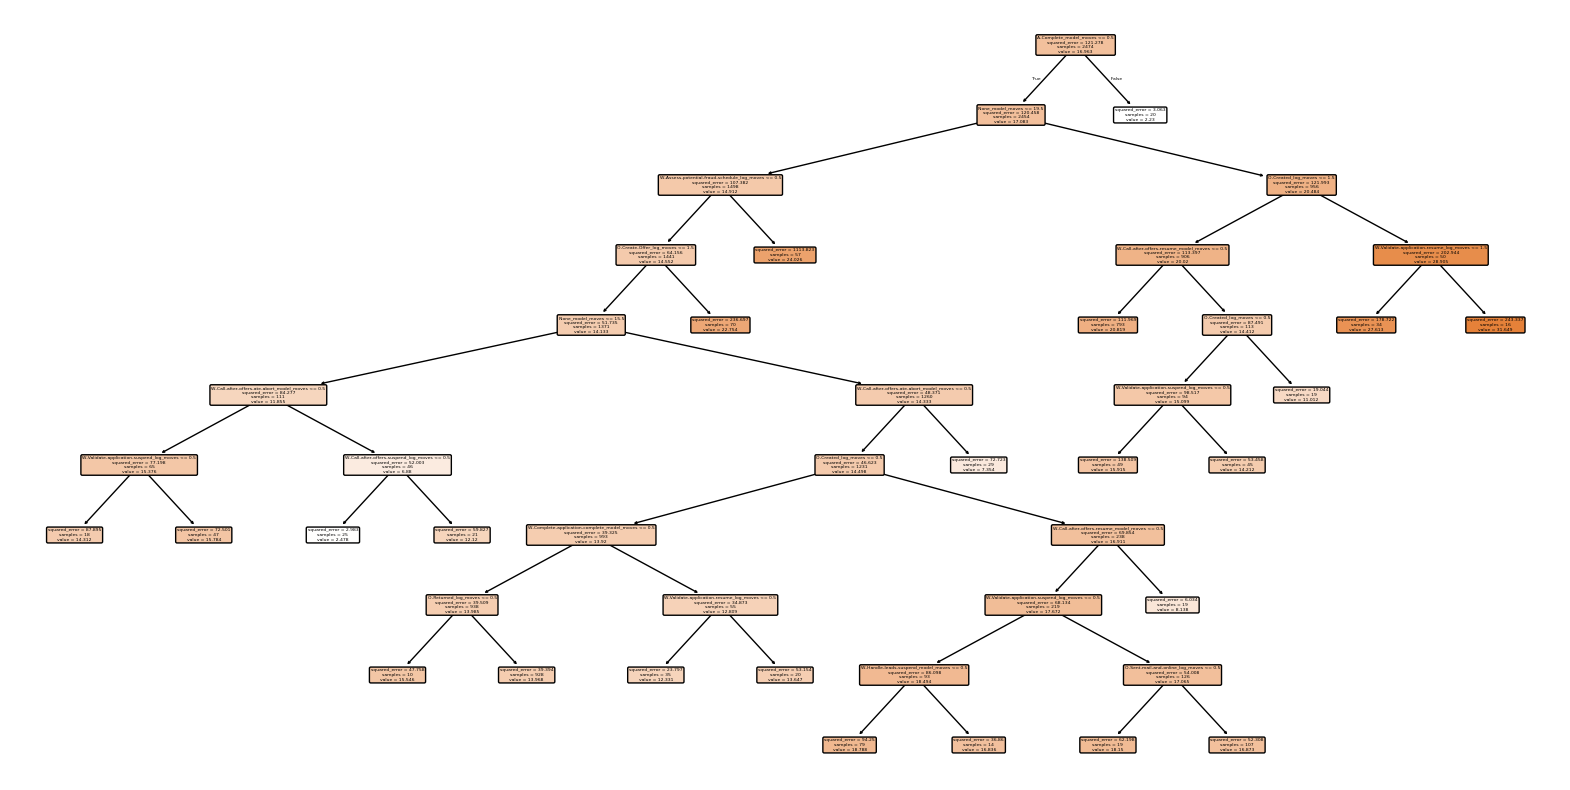

In [65]:
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(best_tree_model, filled=True, feature_names=X.columns, rounded=True)
plt.show()

In [ ]:
from sklearn.tree import export_text

# Derive and print the set of classification rules from the decision tree
rules = export_text(best_tree_model, feature_names=list(X.columns))
print("Classification Rules:\n", rules)

# Use classification rules to split the log
results_df = pd.DataFrame({
    'Actual Class': y_test.reset_index(drop=True),
    'Predicted Class': pd.Series(y_pred_class)
})

# Example of splitting the log based on classification
low_class_log = results_df[results_df['Predicted Class'] == 'low']
medium_class_log = results_df[results_df['Predicted Class'] == 'medium']
high_class_log = results_df[results_df['Predicted Class'] == 'high']

print("Log split based on predicted classes:")
print("Low Throughput Time Log Entries:\n", low_class_log)
print("Medium Throughput Time Log Entries:\n", medium_class_log)
print("High Throughput Time Log Entries:\n", high_class_log)

```markdown
### Optimizing GridSearch Parameters for Decision Tree Regressor

To further optimize the performance of the Decision Tree Regressor, we can adjust the grid search parameters. Here are some strategies to consider:

1. **Increase the Range of Hyperparameters**:
    - **max_depth**: Extend the range to include deeper trees, e.g., `[3, 5, 7, 9, 12, 15, 20, 25]`.
    - **min_samples_split**: Include more values to find the optimal split, e.g., `[2, 5, 8, 12, 15, 20, 25]`.
    - **min_samples_leaf**: Add more values to explore the effect of leaf size, e.g., `[1, 2, 5, 8, 12, 15, 20, 25]`.
    - **max_features**: Consider more options, e.g., `[None, 'sqrt', 'log2', 0.5, 0.75]`.

2. **Increase Cross-Validation Folds**:
    - Increase the number of cross-validation folds to get a more robust estimate of model performance, e.g., `cv=10`.

3. **Use Different Scoring Metrics**:
    - Experiment with different scoring metrics to optimize for various aspects of model performance, e.g., `scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']`.

4. **Adjust GridSearchCV Parameters**:
    - Increase the number of jobs to utilize more computational resources, e.g., `n_jobs=-1`.
    - Set `verbose` to a higher value to get more detailed output during the search process, e.g., `verbose=2`.

5. **Iterative Approach**:
    - Start with a broader range of parameters and gradually narrow down based on the results of initial grid searches.

Here is an example of an updated parameter grid:

```python
param_grid = {
     'max_depth': [3, 5, 7, 9, 12, 15, 20, 25],
     'min_samples_split': [2, 5, 8, 12, 15, 20, 25],
     'min_samples_leaf': [1, 2, 5, 8, 12, 15, 20, 25],
     'max_features': [None, 'sqrt', 'log2', 0.5, 0.75]
}

grid_search = GridSearchCV(
     estimator=DecisionTreeRegressor(random_state=42),
     param_grid=param_grid,
     cv=10,
     n_jobs=-1,
     scoring='neg_mean_absolute_error',
     verbose=2
)
```

By systematically exploring these adjustments, we can identify the optimal set of hyperparameters that improve the model's performance.
```

In [22]:
# Define an updated grid of hyperparameters for GridSearchCV
param_grid = {
    'max_depth': [3, 4, 5, 6, 7,8, 9],
    'min_samples_split': [2, 4, 5, 6, 8, 10, 12, 15, 20, 25],
    'min_samples_leaf': [1, 2, 5, 8, 12, 15, 20, 25],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.75, 'auto']
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    verbose=2
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Extract the best model from the grid search
best_tree_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_days = best_tree_model.predict(X_test)

# Convert predictions back to timedelta format for interpretation
y_pred_timedelta = pd.Series(y_pred_days).apply(lambda days: pd.to_timedelta(days, unit='D'))
y_test_timedelta = pd.Series(y_test).apply(lambda days: pd.to_timedelta(days, unit='D'))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred_days)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_days))
r2 = r2_score(y_test, y_pred_days)

print("Model Performance:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")
print(f"R-squared (R2): {r2:.2f}")

# Display first few results for interpretation
results_df = pd.DataFrame({
    'Actual Throughput Time': y_test_timedelta.reset_index(drop=True),
    'Predicted Throughput Time': y_pred_timedelta
})
print(results_df.head())

Fitting 10 folds for each of 3360 candidates, totalling 33600 fits
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, ma

/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5600 fits failed out of a total of 33600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3509 fits failed with the following error:
Traceback (most recent call last):
  File "/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator.

Model Performance:
Best Parameters: {'max_depth': 6, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 12}
Mean Absolute Error (MAE): 6.47 days
Root Mean Squared Error (RMSE): 9.21 days
R-squared (R2): 0.26
      Actual Throughput Time  Predicted Throughput Time
0 20 days 00:56:41.257999996 13 days 03:20:58.243694916
1 41 days 08:53:06.929999998 17 days 09:53:13.218881628
2  8 days 11:57:34.908999998 12 days 03:35:59.839878050
3    21 days 18:28:18.204000 19 days 18:09:34.441974964
4     0 days 00:57:59.282000  2 days 23:36:18.490038459


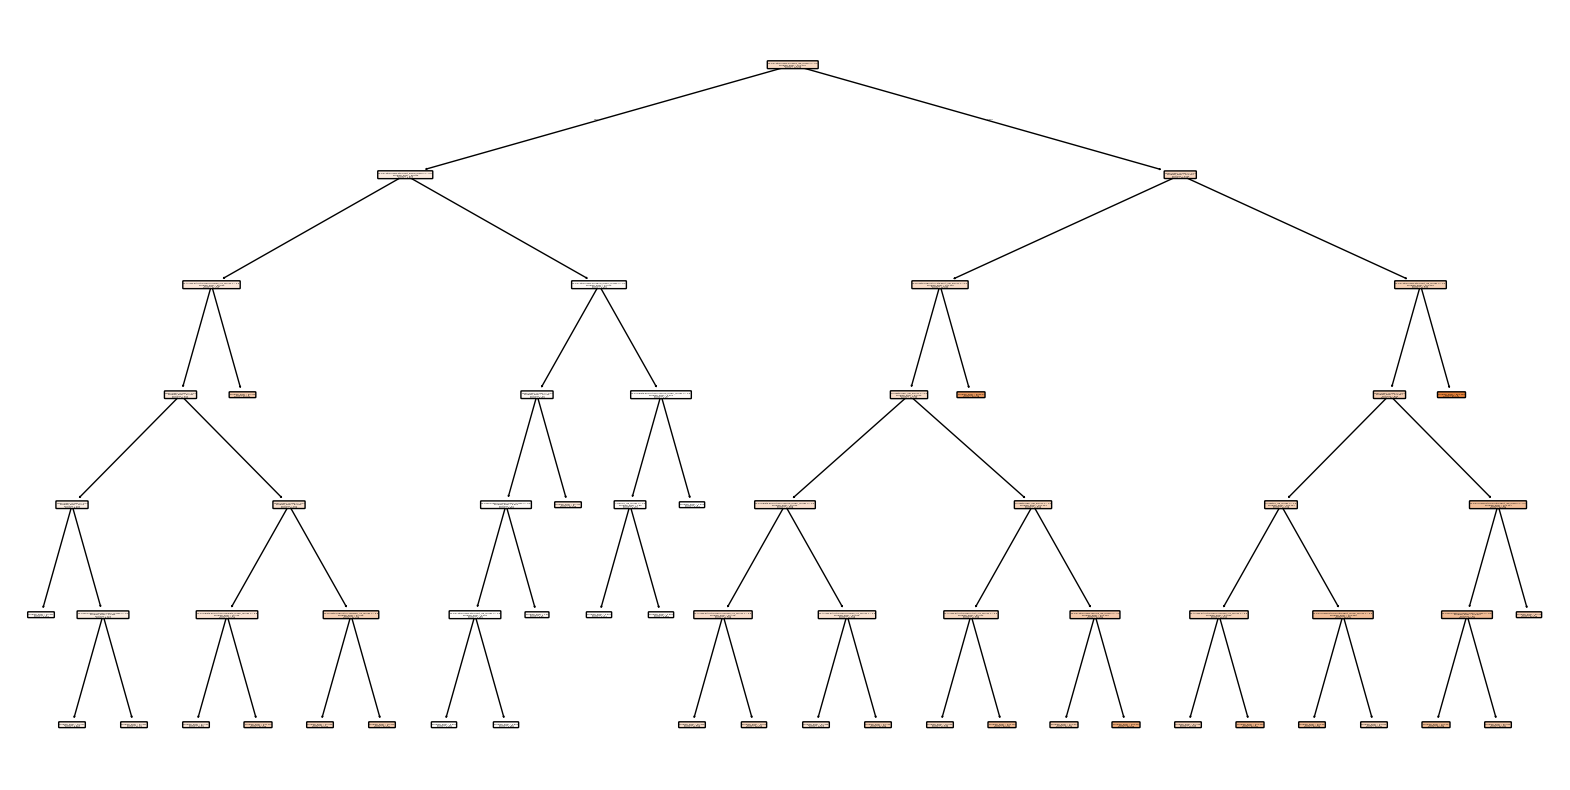

In [23]:
plt.figure(figsize=(20,10))
plot_tree(best_tree_model, filled=True, feature_names=X.columns, rounded=True)
plt.show()

In [25]:
df_filled_minus_1 = df.fillna(-1)

In [26]:
# Separate features (X) and target (y)
X = df_filled_minus_1.drop(columns=["trace_number", "case:throughput_time"])
y = df_filled_minus_1["case:throughput_time"].apply(pd.to_timedelta)  # Ensure column is timedelta

# Convert target variable 'case:throughput_time' to numeric (days) for modeling
y_days = y.apply(lambda x: x.total_seconds() / 86400)  # Convert timedelta to days

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_days, test_size=0.2, random_state=42)

# Define the Decision Tree model with a grid of hyperparameters for optimization
tree_regressor = DecisionTreeRegressor(random_state=42)

# Define a grid of hyperparameters for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 9, 12, 15],
    'min_samples_split': [10, 15, 20, 25, 30],
    'min_samples_leaf': [10, 15, 20, 25, 30],	
    'max_features': [None, 'sqrt', 'log2', 'auto']
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Extract the best model from the grid search
best_tree_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_days = best_tree_model.predict(X_test)

# Convert predictions back to timedelta format for interpretation
y_pred_timedelta = pd.Series(y_pred_days).apply(lambda days: pd.to_timedelta(days, unit='D'))
y_test_timedelta = pd.Series(y_test).apply(lambda days: pd.to_timedelta(days, unit='D'))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred_days)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_days))
r2 = r2_score(y_test, y_pred_days)

print("Model Performance:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")
print(f"R-squared (R2): {r2:.2f}")

# Display first few results for interpretation
results_df = pd.DataFrame({
    'Actual Throughput Time': y_test_timedelta.reset_index(drop=True),
    'Predicted Throughput Time': y_pred_timedelta
})
print(results_df.head())


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Model Performance:
Best Parameters: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 20, 'min_samples_split': 2}
Mean Absolute Error (MAE): 6.28 days
Root Mean Squared Error (RMSE): 9.03 days
R-squared (R2): 0.29
      Actual Throughput Time  Predicted Throughput Time
0 20 days 00:56:41.257999996 13 days 03:23:23.752724141
1 41 days 08:53:06.929999998 21 days 04:44:23.737637500
2  8 days 11:57:34.908999998 13 days 21:08:11.084210522
3    21 days 18:28:18.204000 21 days 21:30:01.058083332
4     0 days 00:57:59.282000  1 days 20:21:54.191461538


/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


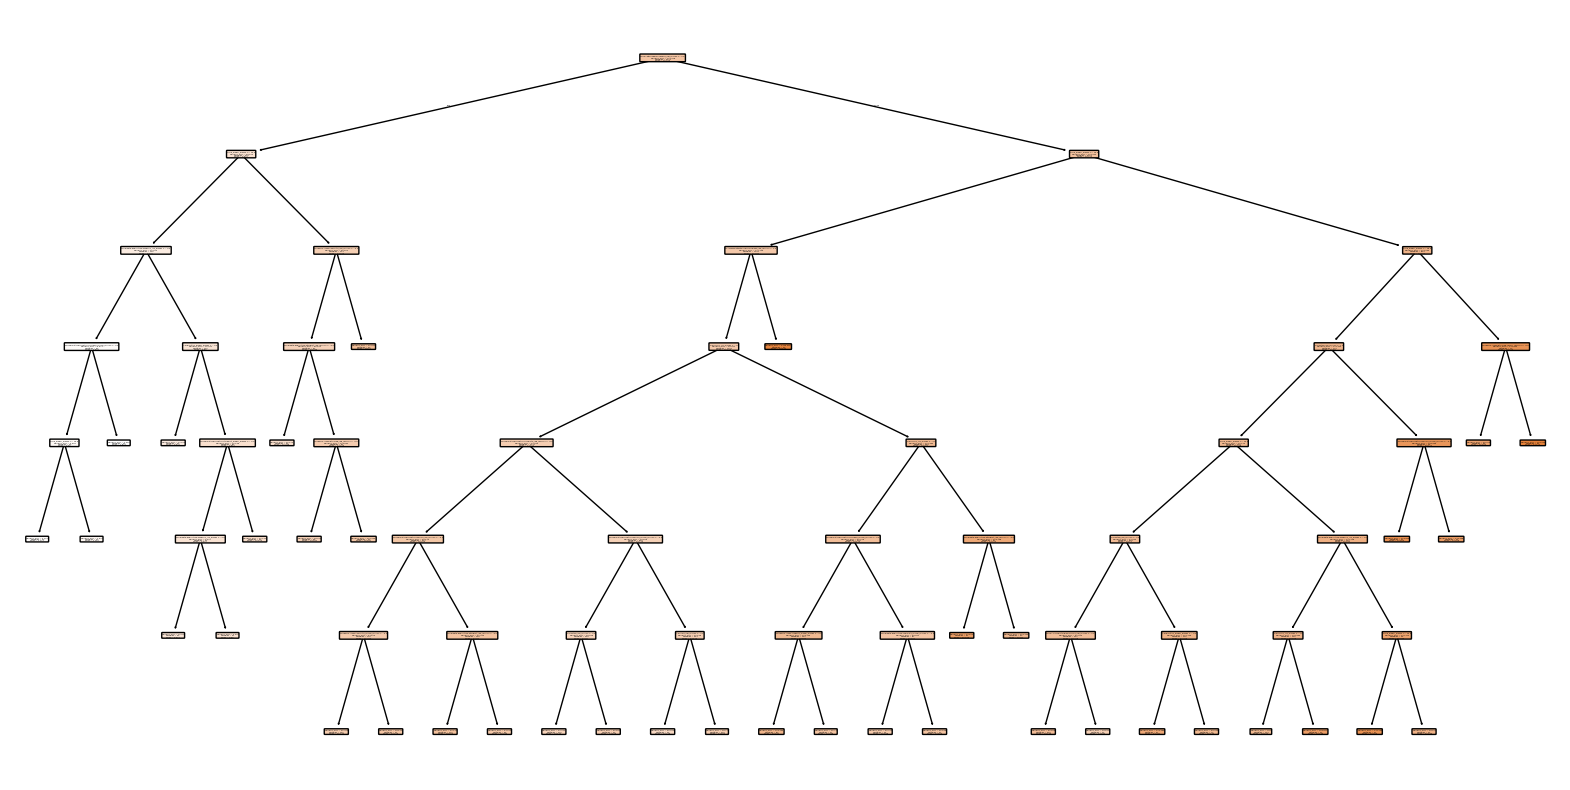

In [27]:
plt.figure(figsize=(20,10))
plot_tree(best_tree_model, filled=True, feature_names=X.columns, rounded=True)
plt.show()

In [37]:
from sklearn.tree import export_text
from collections import Counter

# Derive and print the set of classification rules from the decision tree
rules = export_text(best_tree_model, feature_names=list(X.columns))
print("Classification Rules:\n", rules)

# Use classification rules to split the log
results_df = pd.DataFrame({
    'Actual Throughput Time': y_test.reset_index(drop=True),
    'Predicted Throughput Time': pd.Series(y_pred_days).apply(lambda days: pd.to_timedelta(days, unit='D'))
})

# Rank the rules based on their importance for decisions in the model

# Extract the rules from the decision tree
rules_list = rules.split('\n')

# Count the occurrences of each feature in the rules
feature_counts = Counter()
for rule in rules_list:
    for feature in X.columns:
        if feature in rule:
            feature_counts[feature] += 1

# Rank the features based on their importance
ranked_features = feature_counts.most_common()

# Print the ranked features
print("Ranked Features Based on Importance in Decision Tree Rules:")
for feature, count in ranked_features:
    print(f"{feature}: {count}")

Classification Rules:
 |--- W-Call-after-offers-suspend_log_moves <= 0.50
|   |--- None_model_moves <= 19.50
|   |   |--- W-Validate-application-suspend_log_moves <= -0.50
|   |   |   |--- W-Complete-application-suspend_model_moves <= 0.50
|   |   |   |   |--- None_model_moves <= 15.50
|   |   |   |   |   |--- value: [2.77]
|   |   |   |   |--- None_model_moves >  15.50
|   |   |   |   |   |--- value: [4.19]
|   |   |   |--- W-Complete-application-suspend_model_moves >  0.50
|   |   |   |   |--- value: [1.85]
|   |   |--- W-Validate-application-suspend_log_moves >  -0.50
|   |   |   |--- A-Submitted_model_moves <= -0.50
|   |   |   |   |--- value: [6.97]
|   |   |   |--- A-Submitted_model_moves >  -0.50
|   |   |   |   |--- W-Complete-application-ate-abort_model_moves <= -0.50
|   |   |   |   |   |--- W-Validate-application-suspend_log_moves <= 0.50
|   |   |   |   |   |   |--- value: [8.52]
|   |   |   |   |   |--- W-Validate-application-suspend_log_moves >  0.50
|   |   |   |   |   |

In [67]:
from sklearn.tree import export_text
import numpy as np

# Extract the rules from the decision tree
rules = export_text(best_tree_model, feature_names=list(X.columns))

# Split the rules into a list
rules_list = rules.split('\n')

# Function to calculate Gini impurity
def gini_impurity(probabilities):
    return 1 - sum(p ** 2 for p in probabilities)

# Calculate Gini impurity for each rule
gini_impurities = []
for rule in rules_list:
    if 'value' in rule:
        # Extract the values from the rule
        values = rule.split('value: [')[1].split(']')[0]
        values = list(map(float, values.split(',')))
        total = sum(values)
        probabilities = [v / total for v in values]
        gini = gini_impurity(probabilities)
        gini_impurities.append((rule, gini))

# Sort the rules by Gini impurity in descending order
gini_impurities.sort(key=lambda x: x[1], reverse=True)



# Print the filtered rules
for rule, gini in gini_impurities:
    print(f"Rule: {rule}, Gini Impurity: {gini}")
    


Rule: |   |   |   |   |   |   |   |--- value: [14.31], Gini Impurity: 0.0
Rule: |   |   |   |   |   |   |   |--- value: [15.78], Gini Impurity: 0.0
Rule: |   |   |   |   |   |   |   |--- value: [2.48], Gini Impurity: 0.0
Rule: |   |   |   |   |   |   |   |--- value: [12.12], Gini Impurity: 0.0
Rule: |   |   |   |   |   |   |   |   |   |--- value: [15.55], Gini Impurity: 0.0
Rule: |   |   |   |   |   |   |   |   |   |--- value: [13.97], Gini Impurity: 0.0
Rule: |   |   |   |   |   |   |   |   |   |--- value: [12.33], Gini Impurity: 0.0
Rule: |   |   |   |   |   |   |   |   |   |--- value: [13.65], Gini Impurity: 0.0
Rule: |   |   |   |   |   |   |   |   |   |   |--- value: [18.79], Gini Impurity: 0.0
Rule: |   |   |   |   |   |   |   |   |   |   |--- value: [16.84], Gini Impurity: 0.0
Rule: |   |   |   |   |   |   |   |   |   |   |--- value: [18.15], Gini Impurity: 0.0
Rule: |   |   |   |   |   |   |   |   |   |   |--- value: [16.87], Gini Impurity: 0.0
Rule: |   |   |   |   |   |   |  

In [36]:
from sklearn.tree import export_text
from collections import Counter

# Derive and print the set of classification rules from the decision tree
rules = export_text(best_tree_model, feature_names=list(X.columns))
print("Classification Rules:\n", rules)

# Use classification rules to split the log
results_df = pd.DataFrame({
    'Actual Throughput Time': y_test.reset_index(drop=True),
    'Predicted Throughput Time': pd.Series(y_pred_days).apply(lambda days: pd.to_timedelta(days, unit='D'))
})

# Rank the rules based on their importance for decisions in the model

# Extract the rules from the decision tree
rules_list = rules.split('\n')

# Count the occurrences of each feature in the rules
feature_counts = Counter()
for rule in rules_list:
    for feature in X.columns:
        if feature in rule:
            feature_counts[feature] += 1

# Rank the features based on their importance
ranked_features = feature_counts.most_common()

# Print the ranked features
print("Ranked Features Based on Importance in Decision Tree Rules:")
for feature, count in ranked_features:
    print(f"{feature}: {count}")

# Define thresholds based on definition 6
low_threshold = 5  # Example threshold for low throughput time
high_threshold = 15  # Example threshold for high throughput time

# Example of splitting the log based on classification
low_class_log = results_df[results_df['Predicted Throughput Time'] < pd.Timedelta(days=low_threshold)]
medium_class_log = results_df[(results_df['Predicted Throughput Time'] >= pd.Timedelta(days=low_threshold)) & (results_df['Predicted Throughput Time'] < pd.Timedelta(days=high_threshold))]
high_class_log = results_df[results_df['Predicted Throughput Time'] >= pd.Timedelta(days=high_threshold)]

print("Log split based on predicted classes:")
print("Low Throughput Time Log Entries:\n", low_class_log)
print("Medium Throughput Time Log Entries:\n", medium_class_log)
print("High Throughput Time Log Entries:\n", high_class_log)

Classification Rules:
 |--- W-Call-after-offers-suspend_log_moves <= 0.50
|   |--- None_model_moves <= 19.50
|   |   |--- W-Validate-application-suspend_log_moves <= -0.50
|   |   |   |--- W-Complete-application-suspend_model_moves <= 0.50
|   |   |   |   |--- None_model_moves <= 15.50
|   |   |   |   |   |--- value: [2.77]
|   |   |   |   |--- None_model_moves >  15.50
|   |   |   |   |   |--- value: [4.19]
|   |   |   |--- W-Complete-application-suspend_model_moves >  0.50
|   |   |   |   |--- value: [1.85]
|   |   |--- W-Validate-application-suspend_log_moves >  -0.50
|   |   |   |--- A-Submitted_model_moves <= -0.50
|   |   |   |   |--- value: [6.97]
|   |   |   |--- A-Submitted_model_moves >  -0.50
|   |   |   |   |--- W-Complete-application-ate-abort_model_moves <= -0.50
|   |   |   |   |   |--- W-Validate-application-suspend_log_moves <= 0.50
|   |   |   |   |   |   |--- value: [8.52]
|   |   |   |   |   |--- W-Validate-application-suspend_log_moves >  0.50
|   |   |   |   |   |

### Using a Random Forest Regressor as an Alternative to Decision Tree Regressor

A Random Forest Regressor is an ensemble learning method that combines multiple decision trees to improve the predictive performance and control overfitting. Here’s how you can use a Random Forest Regressor as an alternative to the Decision Tree Regressor:

1. **Import the Required Libraries**:
    ```python
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    ```

2. **Define the Random Forest Regressor and Parameter Grid**:
    ```python
    # Define the Random Forest model
    rf_regressor = RandomForestRegressor(random_state=42)

    # Define a grid of hyperparameters for GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9, 12, 15],
        'min_samples_split': [2, 5, 8, 12, 15],
        'min_samples_leaf': [1, 5, 8, 12, 15, 20],
        'max_features': [None, 'sqrt', 'log2']
    }
    ```

3. **Perform Grid Search with Cross-Validation**:
    ```python
    # Perform Grid Search with Cross-Validation
    grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Extract the best model from the grid search
    best_rf_model = grid_search.best_estimator_
    ```

4. **Evaluate the Best Model on the Test Set**:
    ```python
    # Evaluate the best model on the test set
    y_pred_days = best_rf_model.predict(X_test)

    # Convert predictions back to timedelta format for interpretation
    y_pred_timedelta = pd.Series(y_pred_days).apply(lambda days: pd.to_timedelta(days, unit='D'))
    y_test_timedelta = pd.Series(y_test).apply(lambda days: pd.to_timedelta(days, unit='D'))

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred_days)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_days))
    r2 = r2_score(y_test, y_pred_days)

    print("Model Performance:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Mean Absolute Error (MAE): {mae:.2f} days")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")
    print(f"R-squared (R2): {r2:.2f}")

    # Display first few results for interpretation
    results_df = pd.DataFrame({
        'Actual Throughput Time': y_test_timedelta.reset_index(drop=True),
        'Predicted Throughput Time': y_pred_timedelta
    })
    print(results_df.head())
    ```

5. **Visualize the Feature Importances**:
    ```python
    import matplotlib.pyplot as plt

    # Plot feature importances
    feature_importances = best_rf_model.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importances in Random Forest Regressor')
    plt.show()
    ```

By following these steps, you can effectively use a Random Forest Regressor as an alternative to a Decision Tree Regressor, potentially improving the model's performance and robustness.

In [31]:
from sklearn.ensemble import RandomForestRegressor

# Separate features (X) and target (y)
X = df_filled_minus_1.drop(columns=["trace_number", "case:throughput_time"])
y = df_filled_minus_1["case:throughput_time"].apply(pd.to_timedelta)  # Ensure column is timedelta

# Convert target variable 'case:throughput_time' to numeric (days) for modeling
y_days = y.apply(lambda x: x.total_seconds() / 86400)  # Convert timedelta to days

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_days, test_size=0.2, random_state=42)

# Define the Random Forest model
rf_regressor = RandomForestRegressor(random_state=42)

# Define a grid of hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9, 12, 15],
    'min_samples_split': [2, 5, 8, 12, 15],
    'min_samples_leaf': [1, 5, 8, 12, 15, 20],
    'max_features': [None, 'sqrt', 'log2']
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Extract the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_days = best_rf_model.predict(X_test)

# Convert predictions back to timedelta format for interpretation
y_pred_timedelta = pd.Series(y_pred_days).apply(lambda days: pd.to_timedelta(days, unit='D'))
y_test_timedelta = pd.Series(y_test).apply(lambda days: pd.to_timedelta(days, unit='D'))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred_days)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_days))
r2 = r2_score(y_test, y_pred_days)

print("Model Performance:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")
print(f"R-squared (R2): {r2:.2f}")

# Display first few results for interpretation
results_df = pd.DataFrame({
    'Actual Throughput Time': y_test_timedelta.reset_index(drop=True),
    'Predicted Throughput Time': y_pred_timedelta
})
print(results_df.head())


Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Model Performance:
Best Parameters: {'max_depth': 9, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 100}
Mean Absolute Error (MAE): 6.25 days
Root Mean Squared Error (RMSE): 8.89 days
R-squared (R2): 0.31
      Actual Throughput Time  Predicted Throughput Time
0 20 days 00:56:41.257999996 13 days 08:05:19.155754440
1 41 days 08:53:06.929999998 21 days 00:55:02.394598045
2  8 days 11:57:34.908999998 13 days 14:44:47.659890621
3    21 days 18:28:18.204000 21 days 22:07:38.179787928
4     0 days 00:57:59.282000  2 days 05:26:16.796696951


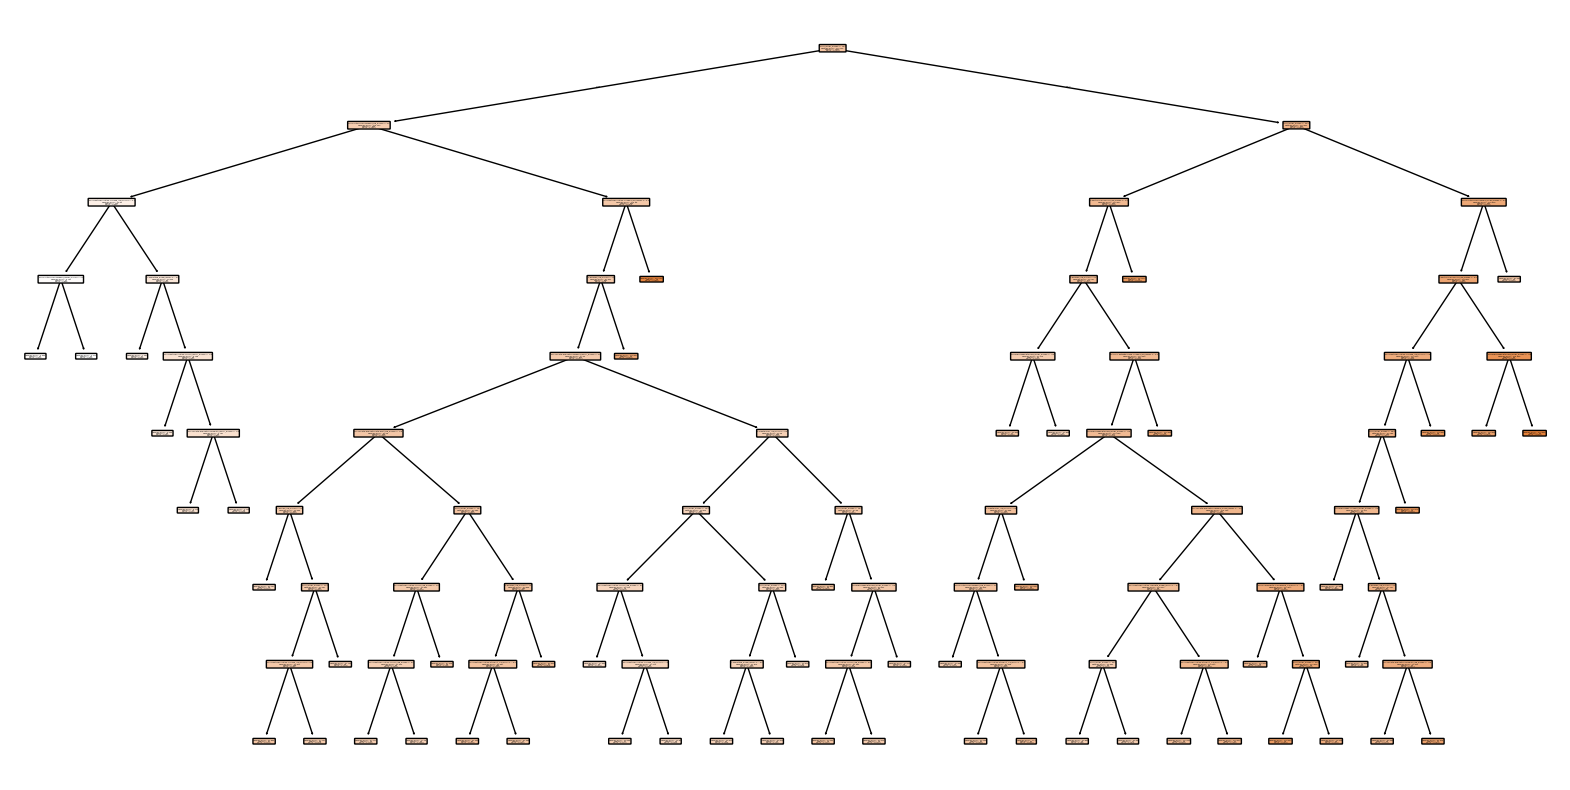

In [35]:
from sklearn.tree import plot_tree

# Extract a single tree from the random forest
single_tree = best_rf_model.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(single_tree, filled=True, feature_names=X.columns, rounded=True)
plt.show()


In [28]:
import numpy as np

df_filled_minus_infinity = df.fillna(-np.inf)

In [29]:
# Separate features (X) and target (y)
X = df_filled_minus_infinity.drop(columns=["trace_number", "case:throughput_time"])
y = df_filled_minus_infinity["case:throughput_time"].apply(pd.to_timedelta)  # Ensure column is timedelta

# Convert target variable 'case:throughput_time' to numeric (days) for modeling
y_days = y.apply(lambda x: x.total_seconds() / 86400)  # Convert timedelta to days

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_days, test_size=0.2, random_state=42)

# Define the Decision Tree model with a grid of hyperparameters for optimization
tree_regressor = DecisionTreeRegressor(random_state=42)

# Define a grid of hyperparameters for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 9, 12, 15],
    'min_samples_split': [2, 5, 8, 12, 15],
    'min_samples_leaf': [1, 5, 8, 12, 15, 20],
    'max_features': [None, 'sqrt', 'log2']
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Extract the best model from the grid search
best_tree_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_days = best_tree_model.predict(X_test)

# Convert predictions back to timedelta format for interpretation
y_pred_timedelta = pd.Series(y_pred_days).apply(lambda days: pd.to_timedelta(days, unit='D'))
y_test_timedelta = pd.Series(y_test).apply(lambda days: pd.to_timedelta(days, unit='D'))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred_days)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_days))
r2 = r2_score(y_test, y_pred_days)

print("Model Performance:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")
print(f"R-squared (R2): {r2:.2f}")

# Display first few results for interpretation
results_df = pd.DataFrame({
    'Actual Throughput Time': y_test_timedelta.reset_index(drop=True),
    'Predicted Throughput Time': y_pred_timedelta
})
print(results_df.head())


Fitting 5 folds for each of 540 candidates, totalling 2700 fits


ValueError: 
All the 2700 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2700 fits failed with the following error:
Traceback (most recent call last):
  File "/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 1377, in fit
    super()._fit(
  File "/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 257, in _fit
    self._compute_missing_values_in_feature_mask(X)
  File "/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 222, in _compute_missing_values_in_feature_mask
    _assert_all_finite_element_wise(X, xp=np, allow_nan=True, **common_kwargs)
  File "/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains infinity or a value too large for dtype('float32').


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV



# Data Preparation
# Handle missing values and preprocess the data
df.fillna(0, inplace=True)

# Feature Extraction
# Extract relevant features for the decision tree model
features = df.drop(columns=['trace_number', 'case:throughput_time'])
target = df['case:throughput_time']

# Convert the target variable to a numerical format (e.g., total seconds)
target = target.apply(lambda x: pd.Timedelta(x).total_seconds())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9, 12],
    'min_samples_split': [2,5,8,12,15],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the grid search with cross-validation
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Model Training

# Initialize the decision tree regressor
model = DecisionTreeRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Conformance Checking
# Predict the throughput time for the test set
y_pred = model.predict(X_test)

# Interpretation
# Evaluate the model performance

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")



Best Parameters: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
Mean Squared Error: 893168976335.9595
R^2 Score: -0.04315415832818226


/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
375 fits failed out of a total of 1125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
195 fits failed with the following error:
Traceback (most recent call last):
  File "/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._va

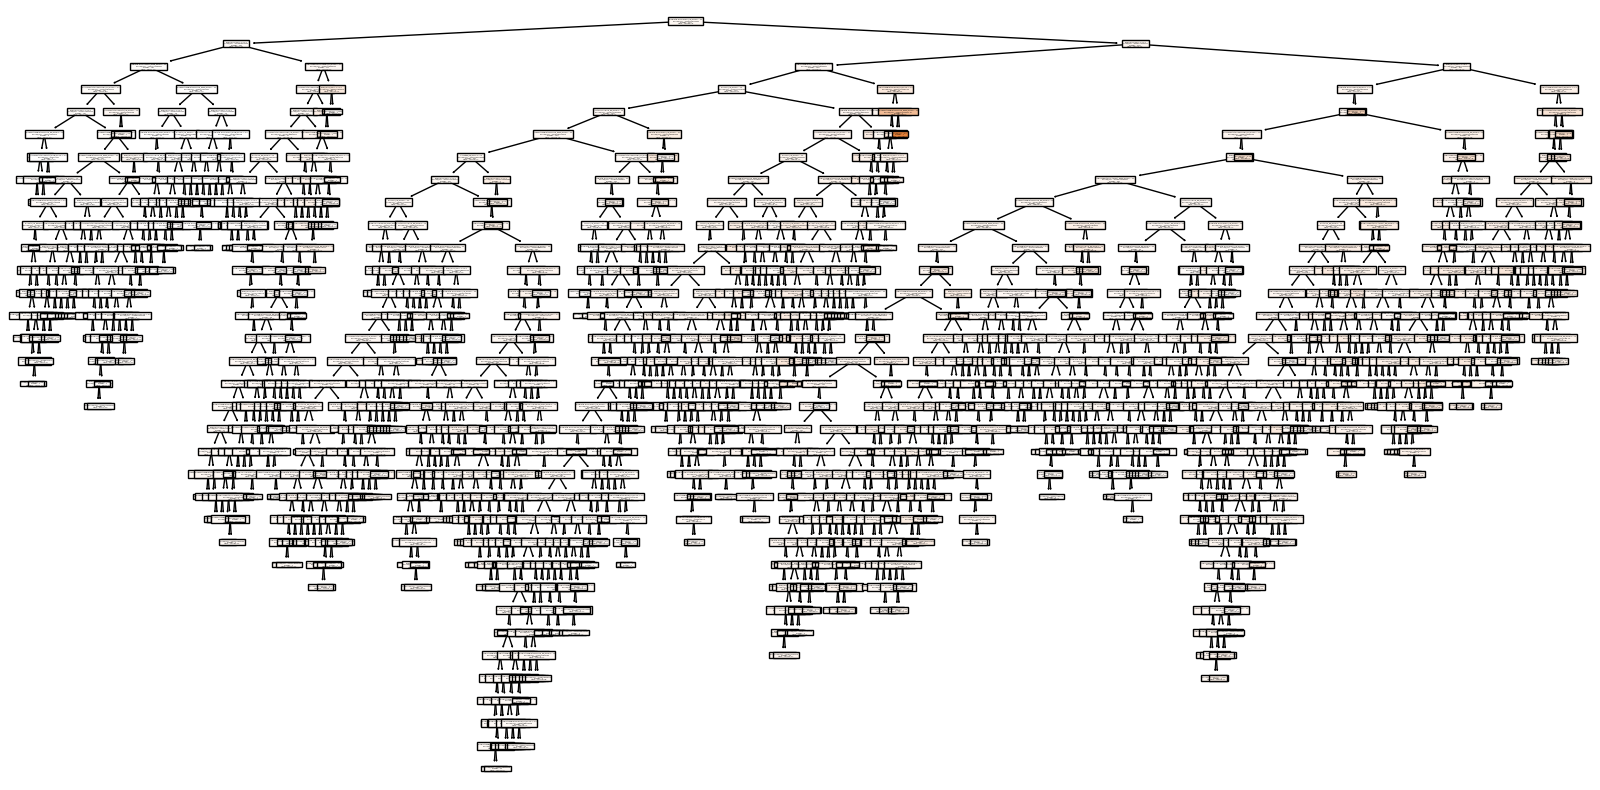

In [14]:
# Visualize the decision tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=features.columns)
plt.show()